In [1]:
#--------------------------------
## IMPORTS
#--------------------------------
import sys
import os

# set the path to find the modules
sys.path.insert(0, '../005_src/') #use relative path
os.chdir("../005_src")

from config import *

----------------------------------------
Packages import successful
Variables import successful
Helper Functions import successful
Functions import successful
Functions xml import successful
Functions graph import successful
Functions GCN import successful
Functions import successful
----------------------------------------
root directory: /storage/remote/atcremers50/ss21_multiagentcontrol/
input directory: /storage/remote/atcremers50/ss21_multiagentcontrol/004_data/
output directory: /storage/remote/atcremers50/ss21_multiagentcontrol/006_model_output/
----------------------------------------



In [2]:
device = cudaOverview()

CUDA not available, running on cpu


In [3]:
from _03_Networks.GCN_002.GCN_model_002 import *
from _03_Networks.GCN_002.GCN_trainer_002 import *
check_import()

imported trainer: GCN_002 at 13h39m18s


In [4]:
##================================
## MODEL VAR
##================================

random_seed = 42
train_size = 0.9  # 80:20 split
batch_size = 100 # maybe 100 is too much...

Nepochs =1000
save_every = 5 # temp pkl, pt, png, can delete after final is stored
maskstat = True
transformstat = False
plotstat = True
printstat = True

training_losses = []
validation_losses = []
lr_rates = []

# create keys and values for all the stuff that you want later on print out in txt files
dict_text_output = {}


In [5]:
##================================
## LOAD DATA
##================================
input_file_name = "20210710-12h13m58s_timesteps5000_ec3500_em7000"
dict_text_output["input_file_name"] = input_file_name

txt_data = os.path.join(GCN_INPUT_FOLDER,f"{input_file_name}.txt")
dict_text_data = read_txt_data(txt_data)

In [6]:
##if plotstat:
#path_figure = read_txt_data(dict_text_data['info_input_df'])["path_figure"]
#Image(open(f'{path_figure}','rb').read())

In [7]:
##if plotstat:
#path_GIF = dict_text_data["path_GIF"]
#Image(open(f'{path_GIF}','rb').read())

The function "" select only the rows marked with "training row" True.


In [8]:
df_all,df_selected = select_rows_from_data(input_file_name,drop_col = True)
df_all.loc[15]

data_x                [[180.0, 19.49, 1.0], [0.0, 16.23, 1.0], [90.0...
data_pos                [[98.4, 29.75], [101.6, 107.05], [31.88, 98.4]]
data_edges                                       [[0, 0, 1], [1, 2, 2]]
data_edges_renamed                               [[0, 0, 1], [1, 2, 2]]
data_y                      [[101.6, 140.07, 0.0], [55.94, 98.4, 90.0]]
data_edges_attr                                         [2.0, 1.9, 2.2]
training_row                                                      False
Name: 15, dtype: object

In [9]:
len(df_selected), len(df_all)

(3377, 4995)

In [10]:
df_input = df_selected

In [11]:
dict_text_data.keys()

dict_keys(['max_num_veh', 'date', 'time', 'usr', 'env', 'path_input_df', 'info_input_df', 'sim_duration_timesteps', 'edge_creation_radius', 'edge_maintenance_radius', 'edge_weights_option', 'predict_after_timesteps', 'savestat', 'delete_temporary_files', 'plotstat', 'path_GCN_input', 'path_GIF'])

In [12]:
# get the max number of vehicle per time step M
# input data_x [Mx3]
# input data_pos [Mx2]
# output y [Mx3]
M = int(dict_text_data['max_num_veh'])
print (f"max_num_veh at each timestep: {M}")
print (f"sim_duration_timesteps: {dict_text_data['sim_duration_timesteps']}")

max_num_veh at each timestep: 10
sim_duration_timesteps: 5000


In [13]:
##================================
## TRAIN AND VALIDATION 
##================================
c = df_input.index.tolist()
train_frames, valid_frames = train_test_split(
                                c,
                                random_state=random_seed,
                                train_size=train_size,
                                shuffle=True)

valid_frames, test_frames = train_test_split(
                                valid_frames,
                                random_state=random_seed,
                                train_size=0.9,
                                shuffle=True)
#print (f"{train_frames=}")
#print (f"\n{valid_frames=}")
#print (f"\n{test_frames=}")
dict_text_output["train_frames"] = train_frames
dict_text_output["valid_frames"] = valid_frames
dict_text_output["test_frames"] = test_frames

In [14]:
##================================
## TRANSFORMATIONS
##================================
if transformstat: 
    # not implemented, not needed i think
    transforms_training = None
    transforms_validation = None
else:
    transforms_training = None
    transforms_validation = None

In [15]:
exclude_yaw = True
paddingstat = False
concatenatestat = True

if concatenatestat:
    size_input = 5
    print (f"Input: concatenation(data_x,data_pos) [bacth_size,{size_input}]")
else:
    size_input = 3
    print (f"Input: concatenation(data_x) [bacth_size,{size_input}]")
if exclude_yaw:
    size_output = 2
    print (f"Predicting: X, Y [bacth_size,{size_output}]")
else:
    size_output = 3
    print (f"Predicting: X, Y, Yaw [bacth_size,{size_output}]")

Input: concatenation(data_x,data_pos) [bacth_size,5]
Predicting: X, Y [bacth_size,2]


In [16]:
print (f"> CREATING THE DATASET")
##================================
## CREATING THE DATASET
##================================

dataset_train = Dataset_GCN_002(
                     df_input,
                     train_frames,
                     #transform=transforms_training,
                     M = M,
                     printstat = False,
                     concatenatestat = concatenatestat,
                     paddingstat = paddingstat,
                     exclude_yaw = exclude_yaw
                     )
dataset_val = Dataset_GCN_002(
                     df_input,
                     valid_frames,
                     M = M,
                     concatenatestat = concatenatestat,
                     paddingstat = paddingstat,
                     exclude_yaw = exclude_yaw
                     )
dataset_test = Dataset_GCN_002(
                     df_input,
                     test_frames,
                     M = M,
                     concatenatestat = concatenatestat,
                     paddingstat = paddingstat,
                     exclude_yaw = exclude_yaw
                     )
printif(dataset_train, n = 10)

  1%|          | 16/3039 [00:00<00:19, 152.51it/s]

> CREATING THE DATASET


100%|██████████| 34/34 [00:00<00:00, 162.54it/s]

0) Data(edge_attr=[45], edge_index=[2, 45], pos=[10, 2], x=[10, 5], y=[10, 2])
1) Data(edge_attr=[45], edge_index=[2, 45], pos=[10, 2], x=[10, 5], y=[10, 2])
2) Data(edge_attr=[45], edge_index=[2, 45], pos=[10, 2], x=[10, 5], y=[10, 2])
3) Data(edge_attr=[45], edge_index=[2, 45], pos=[10, 2], x=[10, 5], y=[10, 2])
4) Data(edge_attr=[45], edge_index=[2, 45], pos=[10, 2], x=[10, 5], y=[10, 2])
...
3034) Data(edge_attr=[45], edge_index=[2, 45], pos=[10, 2], x=[10, 5], y=[10, 2])
3035) Data(edge_attr=[45], edge_index=[2, 45], pos=[10, 2], x=[10, 5], y=[10, 2])
3036) Data(edge_attr=[45], edge_index=[2, 45], pos=[10, 2], x=[10, 5], y=[10, 2])
3037) Data(edge_attr=[45], edge_index=[2, 45], pos=[10, 2], x=[10, 5], y=[10, 2])
3038) Data(edge_attr=[45], edge_index=[2, 45], pos=[10, 2], x=[10, 5], y=[10, 2])


In [17]:
dataset_train[0]

Data(edge_attr=[45], edge_index=[2, 45], pos=[10, 2], x=[10, 5], y=[10, 2])

In [18]:
##================================
# DataLoader
##================================
train_loader = DataLoader(dataset_train, batch_size=10, shuffle=False)
val_loader = DataLoader(dataset_val, batch_size=10, shuffle=False)
test_loader = DataLoader(dataset_test, batch_size=10, shuffle=False)

In [19]:
print(f"{len(train_loader.dataset)=}")
print(f"{len(val_loader.dataset)=}")
print(f"{len(test_loader.dataset)=}")

len(train_loader.dataset)=3039
len(val_loader.dataset)=304
len(test_loader.dataset)=34


**Input** is the current state of the crossing described by:
* data_pos = positions of the vehicles (x,y)
* data_x = features of the vehicles (yaw,speed, intention)
* edges_indexes = list of outboud and inbound nodes
* edges_attr = weights of these edges

Per timeframe the number of vehicles changes, and so does the number of edges.

**Output** is the state at time t + delta_t, specifically:
- the positions (x,y)
- the orientation (yaw) -not now

of all the input vehicles
so sometimes we want to predict 6 values, (x,t,yaw) for two cars, but sometimes is much more!


**how to deal with variable size input/output?**

first thought: use a matrix of fixed size Mx3 for the features and Mx2 for the positions, to predict a fixed size matrix Mx3, where M is the max number of vehicles at each timeframe in the simulation and all but the ones that are actually non zero as input are non zero as output.

**what about the edges then?** i think it wasnt a problem to have a different number of edges

## GCN

In [34]:
model = GCN(num_input_features=size_input,
            hidden_channels=50,
            num_output_features =size_output,
            random_seed = random_seed,
           )

criterion = torch.nn.MSELoss()  # Define loss criterion for regression
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)  # Define optimizer.

print(model)

GCN_002(
  (conv1): GCNConv(5, 50)
  (conv2): GCNConv(50, 2)
)


In [35]:
from statistics import mean

In [36]:
mean([1,4])

2.5

In [37]:
training_losses = []
validation_losses = []

In [38]:
# run
for epoch in (range(1, 100)):
    epoch_training_losses = []
    epoch_training_losses = train(
                        model,
                        optimizer,
                        criterion,
                        train_loader,
                        epoch_training_losses,
                        printstat= True
                      )
    epoch_loss = mean(epoch_training_losses)
    training_losses.append(epoch_loss)
    print(f'Epoch: {epoch}, Loss: {epoch_loss}')

Epoch: 1, Loss: 5906.603039390163
Epoch: 2, Loss: 2469.1547048468337
Epoch: 3, Loss: 1854.6900245264958
Epoch: 4, Loss: 1784.64454088713
Epoch: 5, Loss: 1779.5231813129626
Epoch: 6, Loss: 1777.0544610274465
Epoch: 7, Loss: 1774.1951751708984
Epoch: 8, Loss: 1770.925906131142
Epoch: 9, Loss: 1767.2512600547389
Epoch: 10, Loss: 1763.185876143606
Epoch: 11, Loss: 1758.753726758455
Epoch: 12, Loss: 1753.9900890149568
Epoch: 13, Loss: 1748.93442174008
Epoch: 14, Loss: 1743.6334858944542
Epoch: 15, Loss: 1738.1291620354903
Epoch: 16, Loss: 1732.4666543257863
Epoch: 17, Loss: 1726.6811013472707
Epoch: 18, Loss: 1720.8077356438887
Epoch: 19, Loss: 1714.8836264359325
Epoch: 20, Loss: 1709.010482788086
Epoch: 21, Loss: 1703.803486472682
Epoch: 22, Loss: 1702.7172466077302
Epoch: 23, Loss: 1714.8692213359632
Epoch: 24, Loss: 1746.2794201499537
Epoch: 25, Loss: 1768.8739110043175
Epoch: 26, Loss: 1721.977280064633
Epoch: 27, Loss: 1752.4469737002723
Epoch: 28, Loss: 1663.3654528166119
Epoch: 29, L

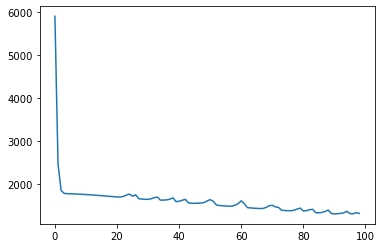

In [39]:
plt.plot(range(0,len(training_losses)), training_losses)

In [40]:
for data in dataset_test[:1]:
    print ("--------------")
    print (data.x)
    print (data.y)
    print (model(data.x, data.edge_index,data.edge_attr).detach())

--------------
tensor([[  0.0000,  11.5500,   1.0000, 101.6000, 131.4800],
        [  0.0000,   8.3700,   1.0000, 101.6000, 109.3300],
        [180.0000,  10.8600,   1.0000,  98.4000,  70.3500],
        [  0.0000,   6.3300,   1.0000, 101.6000,  91.7500],
        [ 90.0000,   0.0000,   0.0000,  92.5600,  98.4000],
        [270.0000,   0.0000,   1.0000, 108.2000, 101.6000],
        [  0.0000,   4.4800,   1.0000, 101.6000,  77.8500],
        [  0.0000,   4.1200,   1.0000, 101.6000,  64.5200],
        [180.0000,   8.3400,   1.0000,  98.4000,  91.1100],
        [270.0000,   9.8800,   3.0000, 163.1900, 101.6000]])
tensor([[101.6000, 161.8000],
        [101.6000, 131.5700],
        [ 98.4000,  41.8600],
        [101.6000, 110.4500],
        [ 92.5600,  98.4000],
        [108.2000, 101.6000],
        [101.6000,  91.7700],
        [101.6000,  74.5800],
        [ 98.4000,  68.6100],
        [138.3400, 101.6000]])
tensor([[55.9726, 55.0945],
        [96.3329, 94.6028],
        [86.1192, 84.6047],

## Plot results

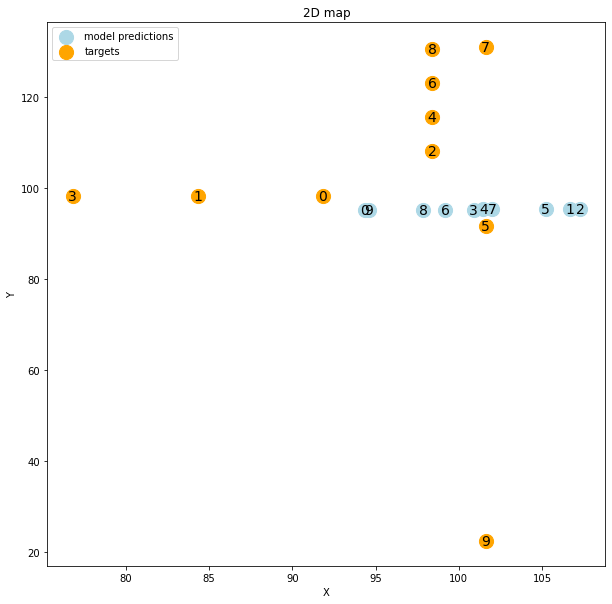

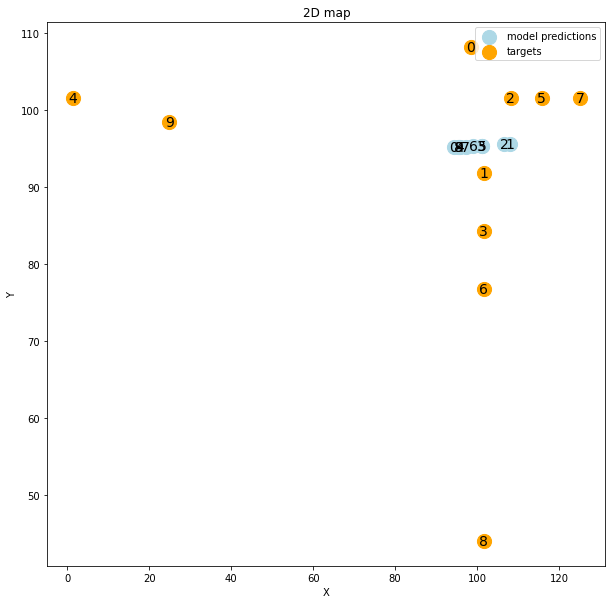

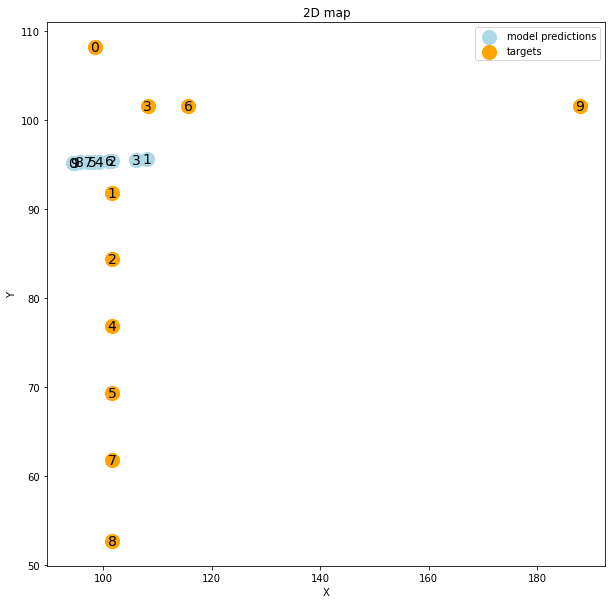

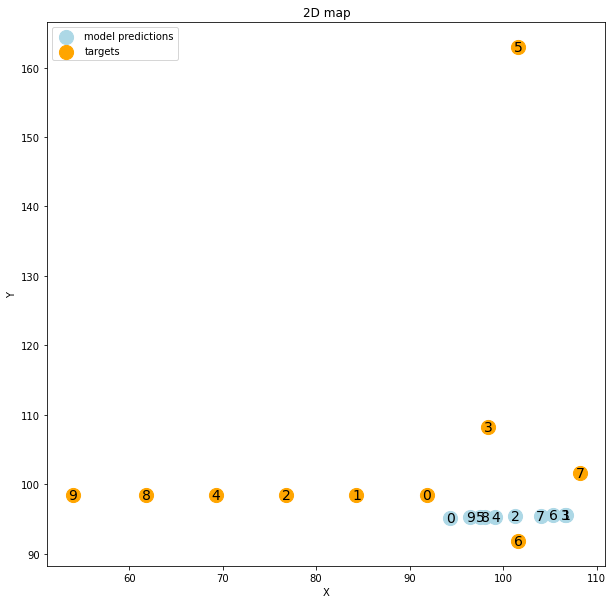

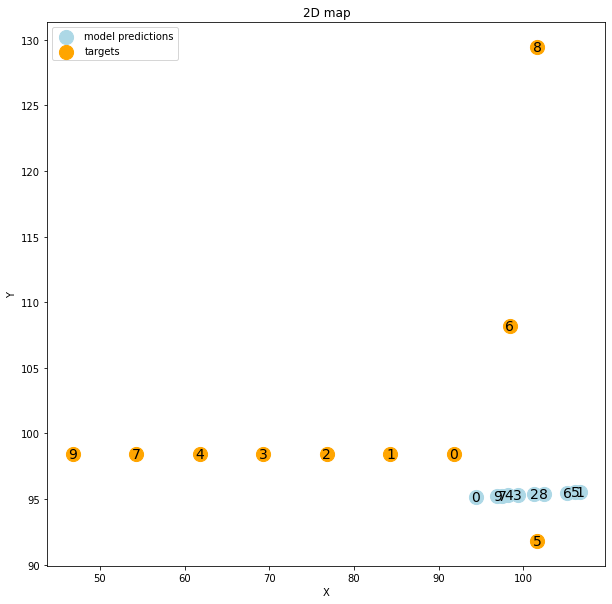

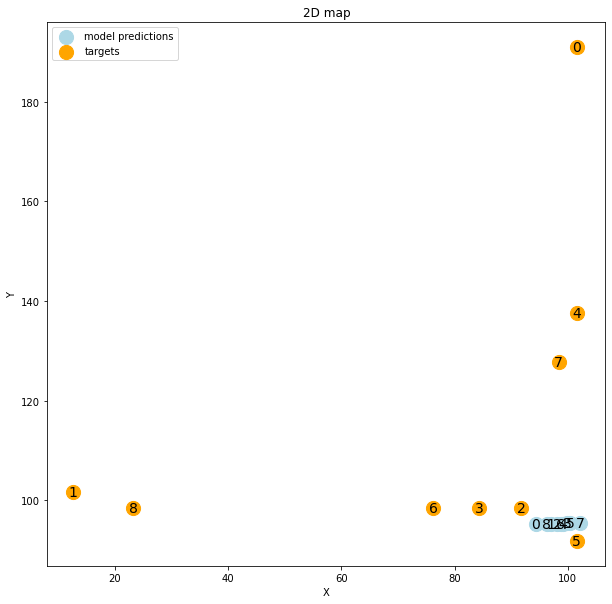

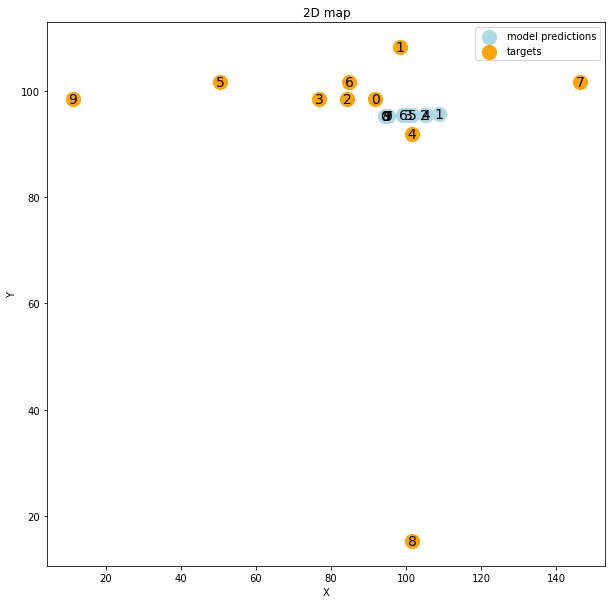

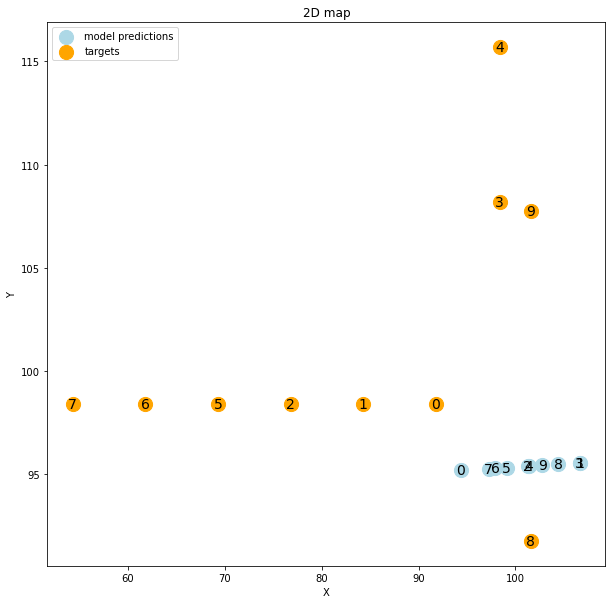

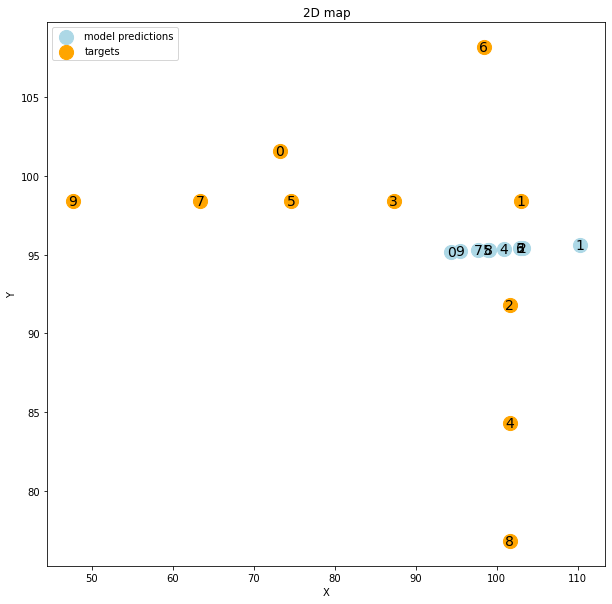

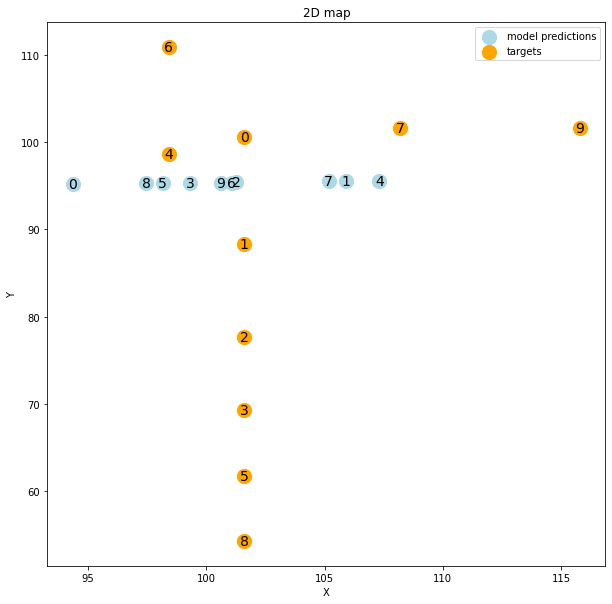

In [26]:
figsize = (10,10)
for data in dataset_train[:10]:
    #print ("--------------")
    #print (data.x)
    #print (data.y)
    pred = model(data.x,
                 data.edge_index,
                 data.edge_attr
                ).detach().numpy()
    
    ## PLOT MODEL PREDICTIONS
    # print (pred)
    X,Y = [], []
    for e in pred:
        X.append(e[0])
        Y.append(e[1])
    
    #select colors
    cmap = list(sns.color_palette("Paired",len(pred)).as_hex())
    fig, ax = plt.subplots(figsize= figsize)
    ax.set_title("2D map");
    ax.set_xlabel("X");
    ax.set_ylabel("Y"); 
    ax.scatter(X,Y, c ="lightblue",s = 200, label= "model predictions")
    
    for i,x in enumerate(X):
        ax.annotate(str(i), (x, Y[i]), ha='center', va='center', size=14)
    
    ## PLOT TARGETS
    X,Y = [], []
    for e in data.y.detach().numpy():
        X.append(e[0])
        Y.append(e[1])
    
    ax.scatter(X,Y, c ="orange",s = 200, label = "targets")
    for i,x in enumerate(X):
        ax.annotate(str(i), (x, Y[i]), ha='center', va='center', size=14)
    ax.legend()
    
    plt.show()